In [1]:
from ensemble_lstm import AutoLSTM
from ensemble_cnn import AutoCNN
from ensemble_rf import AutoRF

In [2]:
import pandas as pd
from pandas import concat
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error

In [3]:
import warnings
tf.get_logger().setLevel('WARNING')

In [27]:
d = np.arange ('2018-05', '2020-05', np.timedelta64 (1,'M'), dtype='datetime64')
d=d.astype('datetime64[D]')
lags = [24]*24
leads = range(1,len(d)+1)
rf_model = AutoRF(data_name='data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
rf_model.run(timearray=d, lags=lags, leads=leads)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Test RMSE: 205.972


<AxesSubplot:xlabel='Date'>

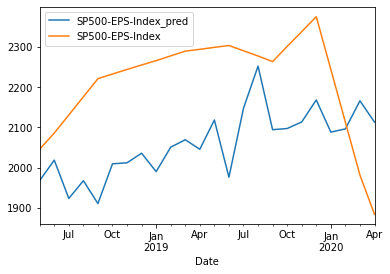

In [28]:
seed_value= 42
tf.random.set_seed(seed_value)
lstm_model = AutoLSTM(data_name='data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
lstm_model.run(timearray=d, use_target=True, lags=lags, leads=leads)
lstm_model.df_result.plot()

Test RMSE: 412.658


<AxesSubplot:xlabel='Date'>

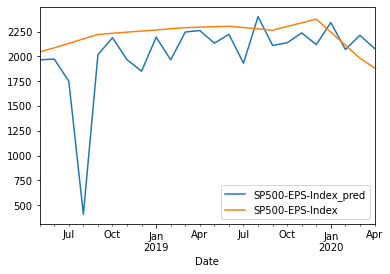

In [29]:
cnn_model = AutoCNN(data_name='data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
cnn_model.run(timearray=d, use_target=True, lags=lags, leads=leads)
cnn_model.df_result.plot()

In [30]:
combined_df = pd.concat([cnn_model.df_result, lstm_model.df_result['SP500-EPS-Index_pred'], 
           rf_model.df_result['SP500-EPS-Index_pred']], axis = 1)
combined_df.columns = ['SP500-EPS_CNN_Pred', 'SP500-EPS-Index','SP500-EPS_LSTM_Pred', 'Period_RF_Pred']

In [31]:
result = [(combined_df.iloc[0]['SP500-EPS_LSTM_Pred'] + combined_df.iloc[0]['SP500-EPS_CNN_Pred'])/2]

In [32]:
cnt = 0
for index in range(1, len(combined_df)):
    if combined_df.iloc[index]['Period_RF_Pred'] != combined_df.iloc[index-1]['Period_RF_Pred']:
        cnt += 1
    if combined_df.iloc[index]['Period_RF_Pred'] == 0:
        if (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] > result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] > result[index-1]):
                result.append(result[-1])
        elif (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] < result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] < result[index-1]):
                tmp = (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] + combined_df.iloc[index]['SP500-EPS_CNN_Pred'])/2
                result.append(tmp)
        else:
            result.append(min(combined_df.iloc[index]['SP500-EPS_CNN_Pred'], combined_df.iloc[index]['SP500-EPS_LSTM_Pred']))
    else:
        if (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] > result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] > result[index-1]):
                tmp = (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] + combined_df.iloc[index]['SP500-EPS_CNN_Pred'])/2
                result.append(tmp)
        elif (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] < result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] < result[index-1]):
                result.append(result[-1])
        else:
            result.append(max(combined_df.iloc[index]['SP500-EPS_CNN_Pred'], combined_df.iloc[index]['SP500-EPS_LSTM_Pred']))
        
            

In [33]:
combined_df['SP500-EPS_Ensemble_Pred'] = result

In [34]:
combined_df

,SP500-EPS_CNN_Pred,SP500-EPS-Index,SP500-EPS_LSTM_Pred,Period_RF_Pred,SP500-EPS_Ensemble_Pred
Date,,,,,
2018-05-01,1965.053990,2045.783100,1967.783224,1.0,1966.418607
2018-06-01,1972.673564,2085.812897,2018.455024,1.0,1995.564294
2018-07-01,1749.199025,2130.724969,1923.204219,1.0,1995.564294
2018-08-01,408.332702,2175.777919,1967.401018,1.0,1995.564294
2018-09-01,2016.780709,2220.947218,1910.589243,1.0,2016.780709
2018-10-01,2187.328460,2232.459915,2009.349034,1.0,2187.328460
2018-11-01,1965.727453,2243.827798,2011.860848,1.0,2187.328460
2018-12-01,1850.438586,2254.998105,2035.691378,1.0,2187.328460
2019-01-01,2193.133476,2265.664511,1989.929212,1.0,2193.133476


In [35]:
from scipy.signal import savgol_filter
combined_df['SP500-EPS_Ensemble_Pred_Smth'] = savgol_filter(combined_df['SP500-EPS_Ensemble_Pred'], 11, cnt+1) 

## '2016-05' to '2018-05'

96.06764483078543
86.69630087346466


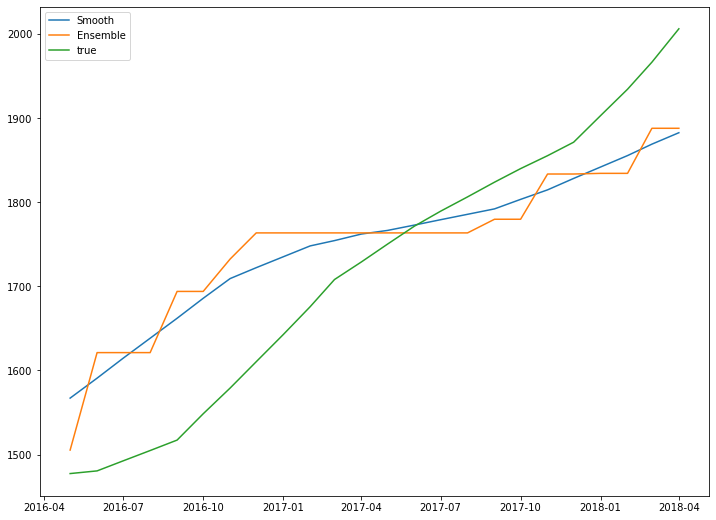

In [26]:
plt.figure(figsize = (12,9))
plt.plot(combined_df['SP500-EPS_Ensemble_Pred_Smth'], label = 'Smooth')
plt.plot(combined_df['SP500-EPS_Ensemble_Pred'], label = 'Ensemble')
plt.plot(combined_df['SP500-EPS-Index'], label = 'true')
#plt.plot(combined_df['SP500-EPS_LSTM_Pred'], label = 'LSTM')
#plt.plot(combined_df['SP500-EPS_CNN_Pred'], label = 'CNN')
plt.legend()
y = combined_df['SP500-EPS-Index']
y_pred = combined_df['SP500-EPS_Ensemble_Pred']
y_pred_smth = combined_df['SP500-EPS_Ensemble_Pred_Smth']
print(np.sqrt(mean_squared_error(y_pred, y)))
print(np.sqrt(mean_squared_error(y_pred_smth, y)))

174.81062402389267
176.3372028925533


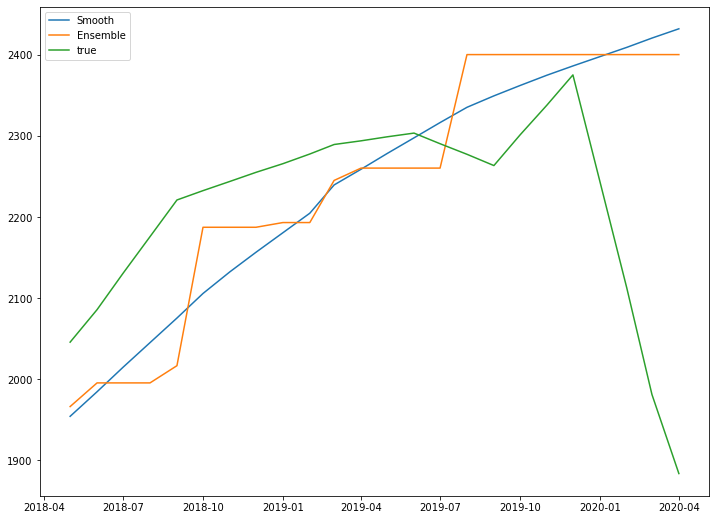

In [36]:
plt.figure(figsize = (12,9))
plt.plot(combined_df['SP500-EPS_Ensemble_Pred_Smth'], label = 'Smooth')
plt.plot(combined_df['SP500-EPS_Ensemble_Pred'], label = 'Ensemble')
plt.plot(combined_df['SP500-EPS-Index'], label = 'true')
#plt.plot(combined_df['SP500-EPS_LSTM_Pred'], label = 'LSTM')
#plt.plot(combined_df['SP500-EPS_CNN_Pred'], label = 'CNN')
plt.legend()
y = combined_df['SP500-EPS-Index']
y_pred = combined_df['SP500-EPS_Ensemble_Pred']
y_pred_smth = combined_df['SP500-EPS_Ensemble_Pred_Smth']
print(np.sqrt(mean_squared_error(y_pred, y)))
print(np.sqrt(mean_squared_error(y_pred_smth, y)))